# Fraud Detection

*This internship project focuses on leveraging machine learning classification techniques to develop an
effective fraud detection system for Fastag transactions. The dataset comprises key features such as
transaction details, vehicle information, geographical location, and transaction amounts. The goal is to
create a robust model that can accurately identify instances of fraudulent activity, ensuring the integrity
and security of Fastag transactions.*

Dataset Description:
1. Transaction_ID: Unique identifier for each transaction.
2. Timestamp: Date and time of the transaction.
3. Vehicle_Type: Type of vehicle involved in the transaction.
4. FastagID: Unique identifier for Fastag.
5. TollBoothID: Identifier for the toll booth.
6. Lane_Type: Type of lane used for the transaction.
7. Vehicle_Dimensions: Dimensions of the vehicle.
8. Transaction_Amount: Amount associated with the transaction.
9. Amount_paid: Amount paid for the transaction.
10. Geographical_Location: Location details of the transaction.
11. Vehicle_Speed: Speed of the vehicle during the transaction.
12. Vehicle_Plate_Number: License plate number of the vehicle.
13. Fraud_indicator: Binary indicator of fraudulent activity (target variable).

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import cufflinks as cf   # !pip install cufflinks

from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression


from sklearn.pipeline import Pipeline

from sklearn.metrics import log_loss, recall_score, accuracy_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_auc_score, auc
from sklearn.metrics import roc_curve, average_precision_score, precision_recall_curve
from sklearn.metrics import make_scorer

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
%matplotlib inline
#%matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# EDA

In [2]:
df = pd.read_csv("FastagFraudDetection.csv")

In [3]:
df.head()

Transaction_ID       Timestamp Vehicle_Type         FastagID TollBoothID  \
0               1  1/6/2023 11:20         Bus   FTG-001-ABC-121       A-101   
1               2  1/7/2023 14:55          Car  FTG-002-XYZ-451       B-102   
2               3  1/8/2023 18:25   Motorcycle              NaN       D-104   
3               4   1/9/2023 2:05        Truck  FTG-044-LMN-322       C-103   
4               5  1/10/2023 6:35          Van  FTG-505-DEF-652       B-102   

  Lane_Type Vehicle_Dimensions  Transaction_Amount  Amount_paid  \
0   Express              Large                 350          120   
1   Regular              Small                 120          100   
2   Regular              Small                   0            0   
3   Regular              Large                 350          120   
4   Express             Medium                 140          100   

                   Geographical_Location  Vehicle_Speed Vehicle_Plate_Number  \
0  13.059816123454882, 77.77068662374292             65           KA11AB1234   
1  13.059816123454882, 77.77068662374292             78           KA66CD5678   
2  13.059816123454882, 77.77068662374292             53           KA88EF9012   
3  13.059816123454882, 77.77068662374292             92           KA11GH3456   
4  13.059816123454882, 77.77068662374292             60           KA44IJ6789   

  Fraud_indicator  
0           Fraud  
1           Fraud  
2       Not Fraud  
3           Fraud  
4           Fraud

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Transaction_ID         5000 non-null   int64 
 1   Timestamp              5000 non-null   object
 2   Vehicle_Type           5000 non-null   object
 3   FastagID               4451 non-null   object
 4   TollBoothID            5000 non-null   object
 5   Lane_Type              5000 non-null   object
 6   Vehicle_Dimensions     5000 non-null   object
 7   Transaction_Amount     5000 non-null   int64 
 8   Amount_paid            5000 non-null   int64 
 9   Geographical_Location  5000 non-null   object
 10  Vehicle_Speed          5000 non-null   int64 
 11  Vehicle_Plate_Number   5000 non-null   object
 12  Fraud_indicator        5000 non-null   object
dtypes: int64(4), object(9)
memory usage: 507.9+ KB


In [5]:
df.isnull().sum()

Transaction_ID             0
Timestamp                  0
Vehicle_Type               0
FastagID                 549
TollBoothID                0
Lane_Type                  0
Vehicle_Dimensions         0
Transaction_Amount         0
Amount_paid                0
Geographical_Location      0
Vehicle_Speed              0
Vehicle_Plate_Number       0
Fraud_indicator            0
dtype: int64

In [6]:
df.shape

(5000, 13)

In [7]:
df.duplicated().sum()

0

In [8]:
df.describe().T

count     mean      std    min      25%      50%  \
Transaction_ID     5000.000 2500.500 1443.520  1.000 1250.750 2500.500   
Transaction_Amount 5000.000  161.062  112.450  0.000  100.000  130.000   
Amount_paid        5000.000  141.261  106.481  0.000   90.000  120.000   
Vehicle_Speed      5000.000   67.851   16.598 10.000   54.000   67.000   

                        75%      max  
Transaction_ID     3750.250 5000.000  
Transaction_Amount  290.000  350.000  
Amount_paid         160.000  350.000  
Vehicle_Speed        82.000  118.000

In [9]:
df.columns

Index(['Transaction_ID', 'Timestamp', 'Vehicle_Type', 'FastagID',
       'TollBoothID', 'Lane_Type', 'Vehicle_Dimensions', 'Transaction_Amount',
       'Amount_paid', 'Geographical_Location', 'Vehicle_Speed',
       'Vehicle_Plate_Number', 'Fraud_indicator'],
      dtype='object')

In [10]:
df['Fraud_indicator'].value_counts()

Not Fraud    4017
Fraud         983
Name: Fraud_indicator, dtype: int64

In [11]:
multiCorr = df.select_dtypes("number").corr()
print(multiCorr.shape)
multiCorr = multiCorr.loc[((multiCorr > .89) & (multiCorr < 1)).any(axis=1),
                          ((multiCorr > .89) & (multiCorr < 1)).any()]
print(multiCorr.shape)

(4, 4)
(0, 0)


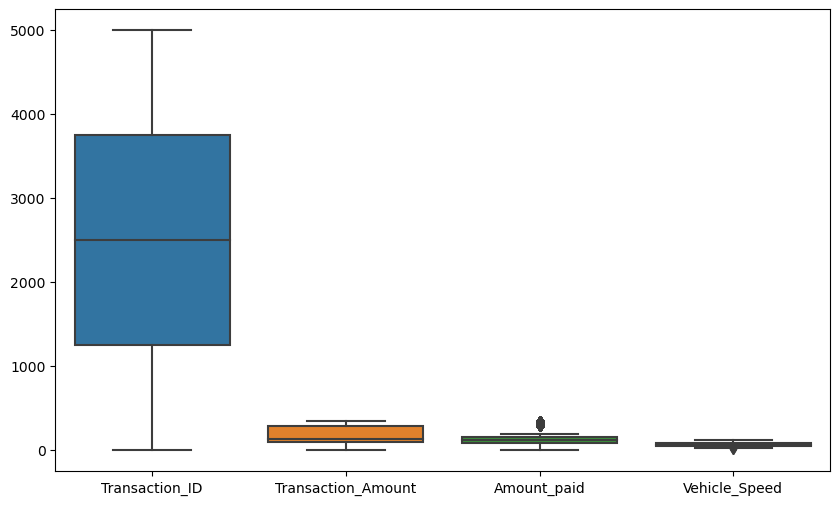

In [12]:
sns.boxplot(df);

In [13]:
sns.boxplot(df.Transaction_Amount);

In [14]:
sns.boxplot(df.Amount_paid);

In [15]:
sns.heatmap(df.corr());

In [16]:
cat_col = df.select_dtypes('object').columns
cat_col

Index(['Timestamp', 'Vehicle_Type', 'FastagID', 'TollBoothID', 'Lane_Type',
       'Vehicle_Dimensions', 'Geographical_Location', 'Vehicle_Plate_Number',
       'Fraud_indicator'],
      dtype='object')

In [17]:
df.Vehicle_Type.nunique()

7

In [18]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

In [19]:
df.Vehicle_Type.unique()

array(['Bus ', 'Car', 'Motorcycle', 'Truck', 'Van', 'Sedan', 'SUV'],
      dtype=object)

In [20]:
df.FastagID.nunique()

4451

In [21]:
df.FastagID.isnull().sum()

549

In [22]:
df.drop('FastagID', axis=1, inplace=True)

In [23]:
df.TollBoothID.unique()

array(['A-101', 'B-102', 'D-104', 'C-103', 'D-105', 'D-106'], dtype=object)

In [24]:
df.Lane_Type.unique()

array(['Express', 'Regular'], dtype=object)

In [25]:
df.Vehicle_Dimensions.unique()

array(['Large', 'Small', 'Medium'], dtype=object)

In [26]:
df.Geographical_Location.nunique()

5

In [27]:
df.Geographical_Location.unique()

array(['13.059816123454882, 77.77068662374292',
       '13.042660878688794, 77.47580097259879',
       '12.84197701525119, 77.67547528176169',
       '12.936687032945434, 77.53113977439017',
       '13.21331620748757, 77.55413526894684'], dtype=object)

In [28]:
df.Vehicle_Plate_Number.nunique()

5000

In [29]:
df.drop("Vehicle_Plate_Number", axis=1, inplace=True)

In [30]:
df.Fraud_indicator.unique()

array(['Fraud', 'Not Fraud'], dtype=object)

In [31]:
cat_col = df.select_dtypes('object').columns
cat_col

Index(['Vehicle_Type', 'TollBoothID', 'Lane_Type', 'Vehicle_Dimensions',
       'Geographical_Location', 'Fraud_indicator'],
      dtype='object')

In [32]:
num_col = df.select_dtypes('number').columns
num_col

Index(['Transaction_ID', 'Transaction_Amount', 'Amount_paid', 'Vehicle_Speed'], dtype='object')

In [33]:
df.Transaction_ID.head()

0    1
1    2
2    3
3    4
4    5
Name: Transaction_ID, dtype: int64

In [34]:
df.drop('Transaction_ID', axis=1, inplace=True)

In [35]:
df.select_dtypes('number')

Transaction_Amount  Amount_paid  Vehicle_Speed
0                    350          120             65
1                    120          100             78
2                      0            0             53
3                    350          120             92
4                    140          100             60
5                    160          100            105
6                    180          160             70
7                    350           90             88
8                    120            0             45
9                      0            0             72
10                   350          120             58
11                   140          120             81
12                   160          120             67
13                   180          180             98
14                   350          120             50
15                   120           90             75
16                     0            0             62
17                   350          120             84
18                   140          120             55
19                   160          160             80
20                   180          100             68
21                   350          350             90
22                   120           90             48
23                     0            0             77
24                   350          120             63
25                   140          140             87
26                   160          100             52
27                   180          120             95
28                   350          350             73
29                   120          120             82
30                     0            0             57
31                   350          350             96
32                   140          100             66
33                   160          160             89
34                   180          120             51
35                   350          350             76
36                   120            0             61
37                     0            0             85
38                   350          350             74
39                   140           90             93
40                   160          120             49
41                   180          180             83
42                   350           90             59
43                   120           90             91
44                     0            0             71
45                   350          140             86
46                   140           90             56
47                   160          160             79
48                   180          180             64
49                   350          120             97
50                   120          120             69
51                     0            0             94
52                   350          100             54
53                   140          140             81
54                   160           90             65
55                   180          180             92
56                   350          350             50
57                   120           90             75
58                     0            0             58
59                   350           90             89
60                   140           90             44
61                   160          160             78
62                   180          180             67
63                   350          350             95
64                   120           90             55
65                     0            0             80
66                   350          350             62
67                   140           90             87
68                   160          160             47
69                   180          100             73
70                   350          350             68
71                   120          120             91
72                     0            0             53
73                   350          100             82
74                   140       

In [36]:
df.head()

Timestamp Vehicle_Type TollBoothID Lane_Type Vehicle_Dimensions  \
0 2023-01-06 11:20:00         Bus        A-101   Express              Large   
1 2023-01-07 14:55:00          Car       B-102   Regular              Small   
2 2023-01-08 18:25:00   Motorcycle       D-104   Regular              Small   
3 2023-01-09 02:05:00        Truck       C-103   Regular              Large   
4 2023-01-10 06:35:00          Van       B-102   Express             Medium   

   Transaction_Amount  Amount_paid                  Geographical_Location  \
0                 350          120  13.059816123454882, 77.77068662374292   
1                 120          100  13.059816123454882, 77.77068662374292   
2                   0            0  13.059816123454882, 77.77068662374292   
3                 350          120  13.059816123454882, 77.77068662374292   
4                 140          100  13.059816123454882, 77.77068662374292   

   Vehicle_Speed Fraud_indicator  
0             65           Fraud  
1             78           Fraud  
2             53       Not Fraud  
3             92           Fraud  
4             60           Fraud

In [37]:
# Apply one-hot encoding with drop_first
df = pd.get_dummies(df, columns=['Fraud_indicator'], drop_first=True)
df.head()


Timestamp Vehicle_Type TollBoothID Lane_Type Vehicle_Dimensions  \
0 2023-01-06 11:20:00         Bus        A-101   Express              Large   
1 2023-01-07 14:55:00          Car       B-102   Regular              Small   
2 2023-01-08 18:25:00   Motorcycle       D-104   Regular              Small   
3 2023-01-09 02:05:00        Truck       C-103   Regular              Large   
4 2023-01-10 06:35:00          Van       B-102   Express             Medium   

   Transaction_Amount  Amount_paid                  Geographical_Location  \
0                 350          120  13.059816123454882, 77.77068662374292   
1                 120          100  13.059816123454882, 77.77068662374292   
2                   0            0  13.059816123454882, 77.77068662374292   
3                 350          120  13.059816123454882, 77.77068662374292   
4                 140          100  13.059816123454882, 77.77068662374292   

   Vehicle_Speed  Fraud_indicator_Not Fraud  
0             65                          0  
1             78                          0  
2             53                          1  
3             92                          0  
4             60                          0

In [38]:
df.rename(columns={'Fraud_indicator_Not Fraud': 'Fraud_indicator'}, inplace=True)


In [39]:
# Fraud = 0
# Not Fraud = 1

In [40]:
df.head()

Timestamp Vehicle_Type TollBoothID Lane_Type Vehicle_Dimensions  \
0 2023-01-06 11:20:00         Bus        A-101   Express              Large   
1 2023-01-07 14:55:00          Car       B-102   Regular              Small   
2 2023-01-08 18:25:00   Motorcycle       D-104   Regular              Small   
3 2023-01-09 02:05:00        Truck       C-103   Regular              Large   
4 2023-01-10 06:35:00          Van       B-102   Express             Medium   

   Transaction_Amount  Amount_paid                  Geographical_Location  \
0                 350          120  13.059816123454882, 77.77068662374292   
1                 120          100  13.059816123454882, 77.77068662374292   
2                   0            0  13.059816123454882, 77.77068662374292   
3                 350          120  13.059816123454882, 77.77068662374292   
4                 140          100  13.059816123454882, 77.77068662374292   

   Vehicle_Speed  Fraud_indicator  
0             65                0  
1             78                0  
2             53                1  
3             92                0  
4             60                0